# Check Results of Runs with Updated XIOS-2

Compare results of SalishSeaCast_Blue runs with XIOS-2 updated to successfully build with GCC-9 compilers against pre-update results.

The update of `salish` to Ubuntu 20.04.2 LTS us to change from GCC-5 compilers and OpenMPI-2 library to GCC-9 and OpenMPI-4.
Builds of NEMO configurations using XIOS-2 at svn r1660 that we have been using since Apr-2019 fail when compiled with GCC-9 due to
memory allocation errors or runaway memory consumption.
Updating XIOS-2 to the upstream trunk in Sep/Oct-2024 resulted in builds that produced successful test runs.
Initial testing was done using svn r2659.
The revision pushed to our XIOS-2 repository on GitHub was svn r2660.  

In [1]:
import sys
from pathlib import Path

import arrow
import cmocean
import matplotlib.pyplot as plt
import xarray

Python and library versions:

In [2]:
import bottleneck
import h5netcdf
import h5py
import matplotlib
import numpy
import pandas
import scipy

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{arrow.__version__=}")

Python sys.version='3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]'
numpy.__version__='2.0.0'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'
arrow.__version__='1.3.0'


In [3]:
results_paths = {
  "baseline": Path("/data/dlatorne/MEOPAR/results/sss150/03jul24-blue/"),
  "r2659_O3": Path("/data/dlatorne/MEOPAR/results/sss150/03jul24-blue-20_04-xios2659/"),
  "r2659_O2": Path("/data/dlatorne/MEOPAR/results/sss150/03jul24-blue-20_04-xios2659-O2/"),
  "r2660": Path("/data/dlatorne/MEOPAR/results/sss150/03jul24-blue-20_04-xios2660/"),
}

In [4]:
drop_vars = {
  "nav_lat", "nav_lon",
  "bounds_nav_lat", "bounds_nav_lon",
  "time_centered", "time_centered_bounds", "time_counter_bounds", 
  "deptht_bounds", "area",
}

In [5]:
baseline_ds = xarray.open_dataset(results_paths["baseline"] / "SalishSea_1h_20240703_20240703_grid_T.nc", drop_variables=drop_vars, engine="h5netcdf")

baseline_ds

<xarray.Dataset> Size: 1GB
Dimensions:       (deptht: 40, time_counter: 6, y: 898, x: 398)
Coordinates:
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 48B 2024-07-03T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    sossheig      (time_counter, y, x) float32 9MB ...
    votemper      (time_counter, deptht, y, x) float32 343MB ...
    vosaline      (time_counter, deptht, y, x) float32 343MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 343MB ...
    e3t           (time_counter, deptht, y, x) float32 343MB ...
Attributes:
    name:         SalishSea_1h_20240703_20240703_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2024-Jul-09 23:28:29 GMT
    uuid:         28a9ffdf-b00d-4764-9a62-62da9013e9dd

## GCC-9 build using `-O3` with XIOS-2 at svn r2659

In [7]:
r2659_O3_ds = xarray.open_dataset(results_paths["r2659_O3"] / "SalishSea_1h_20240703_20240703_grid_T.nc", drop_variables=drop_vars, engine="h5netcdf")

r2659_O3_ds

<xarray.Dataset> Size: 1GB
Dimensions:       (deptht: 40, time_counter: 6, y: 898, x: 398)
Coordinates:
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 48B 2024-07-03T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    sossheig      (time_counter, y, x) float32 9MB ...
    votemper      (time_counter, deptht, y, x) float32 343MB ...
    vosaline      (time_counter, deptht, y, x) float32 343MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 343MB ...
    e3t           (time_counter, deptht, y, x) float32 343MB ...
Attributes:
    name:         SalishSea_1h_20240703_20240703_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2024-Sep-24 00:52:06 GMT
    uuid:         899754f9-4322-43b1-af16-56afd0b9b7f1

Text(0.5, 1.0, 'difference')

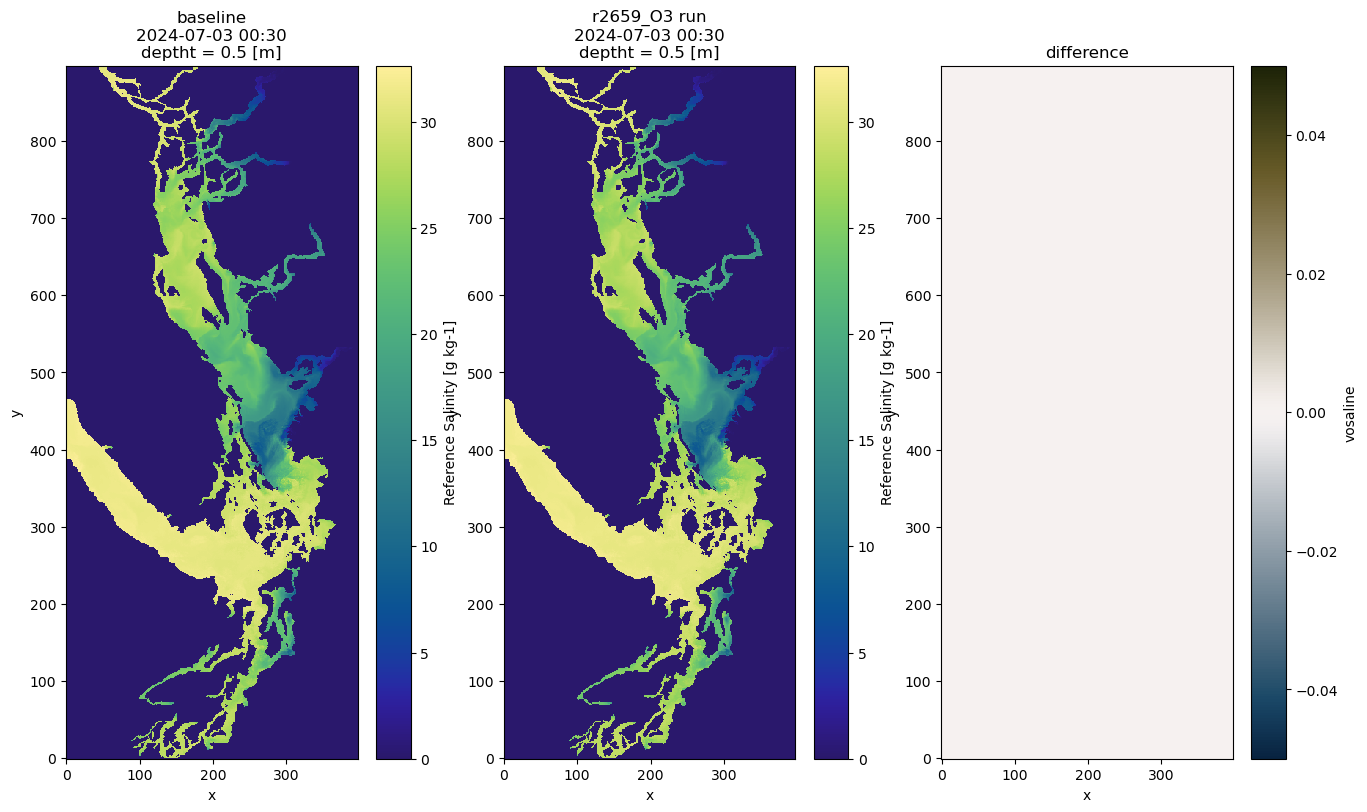

In [8]:
_, (axref, axcomp, axdiff) = plt.subplots(1, 3, figsize=(16, 9))
timestamp = arrow.get(pandas.to_datetime(baseline_ds.time_counter)[0]).format("YYYY-MM-DD HH:mm")

baseline_sal = baseline_ds.vosaline.isel(time_counter=0, deptht=0)
baseline_sal.plot(ax=axref, cmap=cmocean.cm.haline)
axref.set_title(f"baseline\n{timestamp}\n{axref.get_title().split(",")[0]}")

r2659_O3_sal = r2659_O3_ds.vosaline.isel(time_counter=0, deptht=0)
r2659_O3_sal.plot(ax=axcomp, cmap=cmocean.cm.haline)
axcomp.set_title(f"r2659_O3 run\n{timestamp}\n{axcomp.get_title().split(",")[0]}")

(baseline_sal - r2659_O3_sal).plot(ax=axdiff, cmap=cmocean.cm.diff)
axdiff.set_title("difference")

In [9]:
numpy.nanmax(baseline_sal - r2659_O3_sal)

np.float32(0.0)

Identical surface salinity fields indicate that the GCC-9 build using `-O3` with XIOS-2 at svn r2659 produces that same results as the pre-update baseline run.

## GCC-9 build using `-O2` with XIOS-2 at svn r2659

Michael asked if the results were the same with `-O2` in light of the run failure we found in a test with `-O0`.

In [10]:
r2659_O2_ds = xarray.open_dataset(results_paths["r2659_O2"] / "SalishSea_1h_20240703_20240703_grid_T.nc", drop_variables=drop_vars, engine="h5netcdf")

r2659_O2_ds

<xarray.Dataset> Size: 1GB
Dimensions:       (deptht: 40, time_counter: 6, y: 898, x: 398)
Coordinates:
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 48B 2024-07-03T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    sossheig      (time_counter, y, x) float32 9MB ...
    votemper      (time_counter, deptht, y, x) float32 343MB ...
    vosaline      (time_counter, deptht, y, x) float32 343MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 343MB ...
    e3t           (time_counter, deptht, y, x) float32 343MB ...
Attributes:
    name:         SalishSea_1h_20240703_20240703_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-01 21:07:01 GMT
    uuid:         a4e7aca4-2d89-4e8a-861a-c8f0b20e7d5d

Text(0.5, 1.0, 'difference')

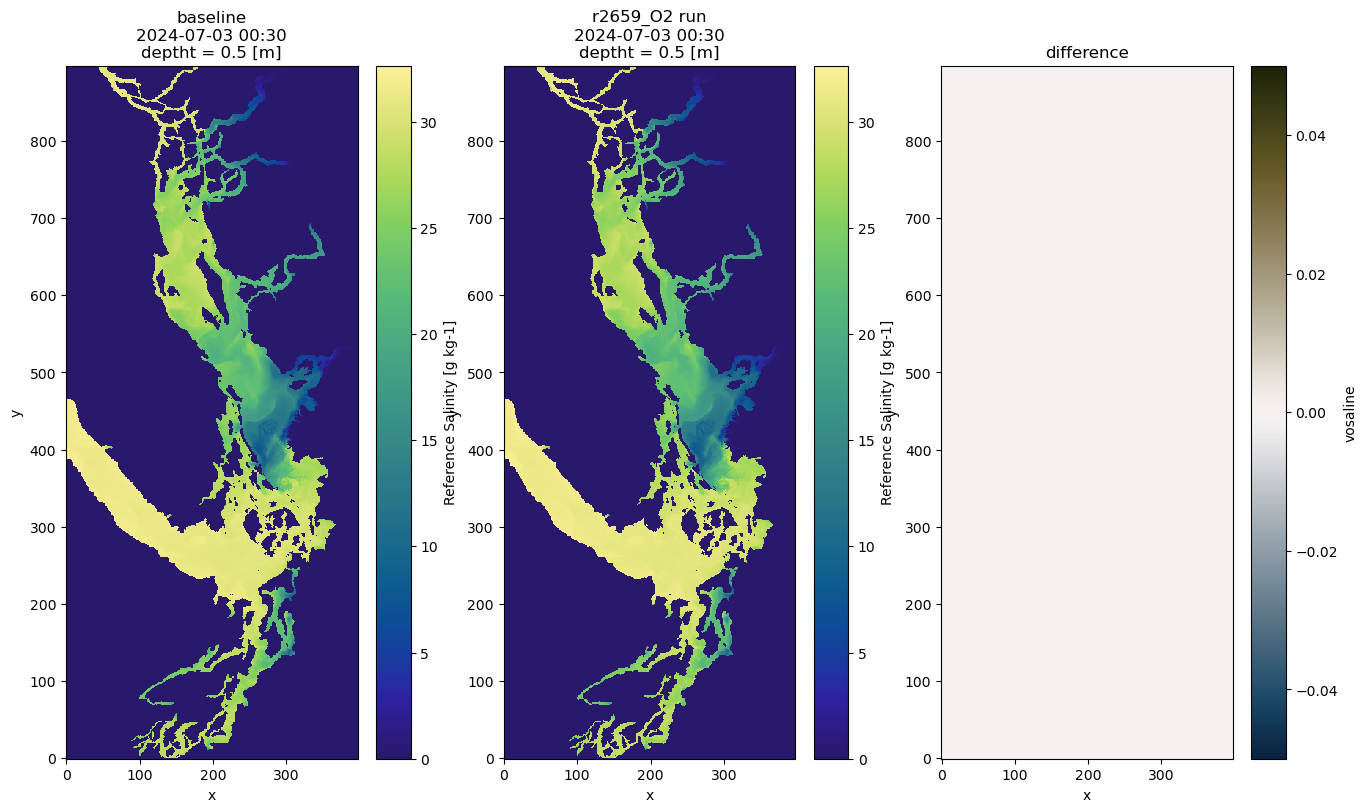

In [11]:
_, (axref, axcomp, axdiff) = plt.subplots(1, 3, figsize=(16, 9))
timestamp = arrow.get(pandas.to_datetime(baseline_ds.time_counter)[0]).format("YYYY-MM-DD HH:mm")

baseline_sal = baseline_ds.vosaline.isel(time_counter=0, deptht=0)
baseline_sal.plot(ax=axref, cmap=cmocean.cm.haline)
axref.set_title(f"baseline\n{timestamp}\n{axref.get_title().split(",")[0]}")

r2659_O2_sal = r2659_O2_ds.vosaline.isel(time_counter=0, deptht=0)
r2659_O2_sal.plot(ax=axcomp, cmap=cmocean.cm.haline)
axcomp.set_title(f"r2659_O2 run\n{timestamp}\n{axcomp.get_title().split(",")[0]}")

(baseline_sal - r2659_O2_sal).plot(ax=axdiff, cmap=cmocean.cm.diff)
axdiff.set_title("difference")

In [12]:
numpy.nanmax(baseline_sal - r2659_O2_sal)

np.float32(0.0)

Identical surface salinity fields indicate that the GCC-9 build using `-O2` with XIOS-2 at svn r2659 produces that same results as the pre-update baseline run.

## GCC-9 build using `-O3` with XIOS-2 at svn r2660

By the time I was ready to update our GitHub XIOS-2 repository,
the upstream XIOS trunk had moved to r2660.
So,
I tested with that too,
to confirm that my merge of the upstream changes into the Git repo had been successful.

In [14]:
r2660_ds = xarray.open_dataset(results_paths["r2660"] / "SalishSea_1h_20240703_20240703_grid_T.nc", drop_variables=drop_vars, engine="h5netcdf")

r2660_ds

<xarray.Dataset> Size: 1GB
Dimensions:       (deptht: 40, time_counter: 6, y: 898, x: 398)
Coordinates:
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 48B 2024-07-03T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    sossheig      (time_counter, y, x) float32 9MB ...
    votemper      (time_counter, deptht, y, x) float32 343MB ...
    vosaline      (time_counter, deptht, y, x) float32 343MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 343MB ...
    e3t           (time_counter, deptht, y, x) float32 343MB ...
Attributes:
    name:         SalishSea_1h_20240703_20240703_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-02 20:47:56 GMT
    uuid:         3cff828e-809a-4bbd-b5e1-41be0485529a

Text(0.5, 1.0, 'difference')

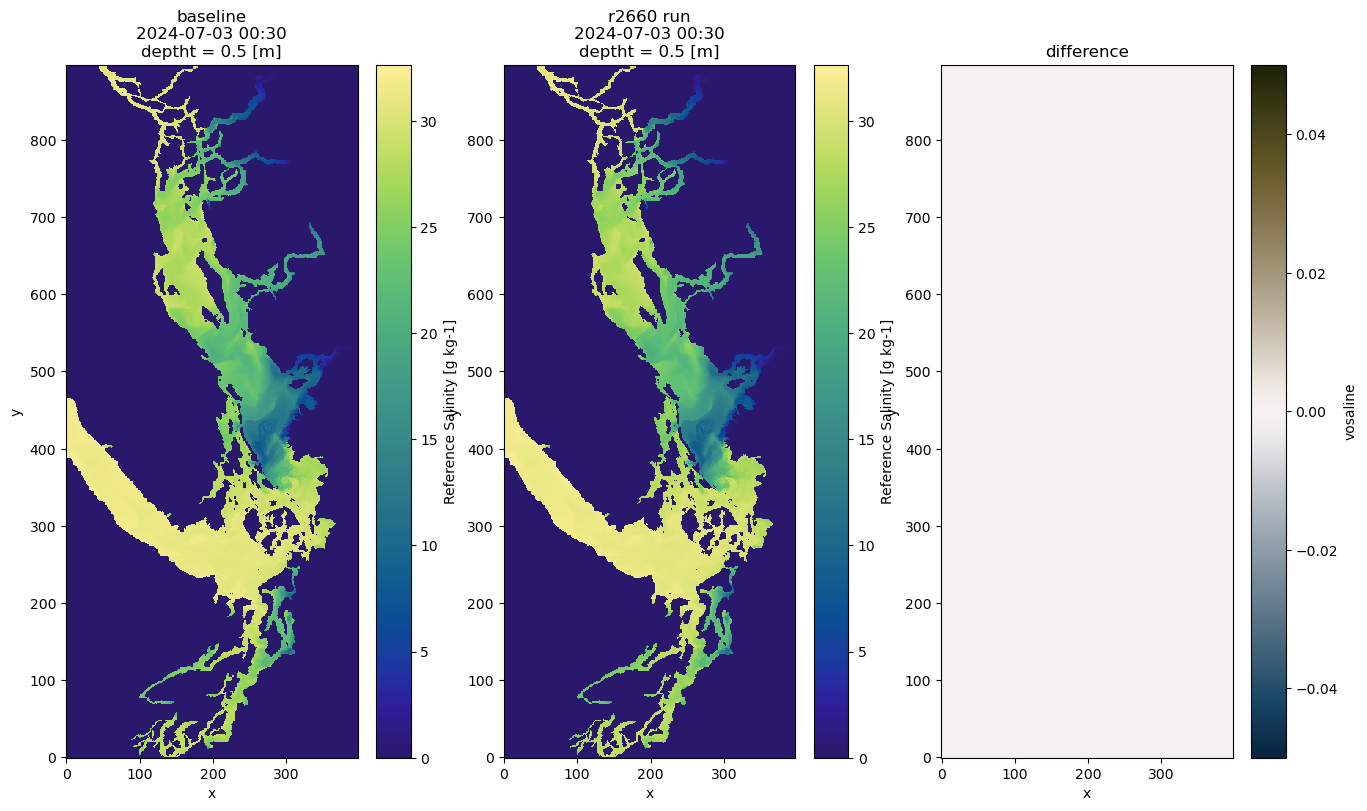

In [15]:
_, (axref, axcomp, axdiff) = plt.subplots(1, 3, figsize=(16, 9))
timestamp = arrow.get(pandas.to_datetime(baseline_ds.time_counter)[0]).format("YYYY-MM-DD HH:mm")

baseline_sal = baseline_ds.vosaline.isel(time_counter=0, deptht=0)
baseline_sal.plot(ax=axref, cmap=cmocean.cm.haline)
axref.set_title(f"baseline\n{timestamp}\n{axref.get_title().split(",")[0]}")

r2660_sal = r2660_ds.vosaline.isel(time_counter=0, deptht=0)
r2660_sal.plot(ax=axcomp, cmap=cmocean.cm.haline)
axcomp.set_title(f"r2660 run\n{timestamp}\n{axcomp.get_title().split(",")[0]}")

(baseline_sal - r2660_sal).plot(ax=axdiff, cmap=cmocean.cm.diff)
axdiff.set_title("difference")

In [16]:
numpy.nanmax(baseline_sal - r2660_sal)

np.float32(0.0)

Identical surface salinity fields indicate that the GCC-9 build using `-O2` with XIOS-2 at svn r2660 produces that same results as the pre-update baseline run.